In [6]:
import os
import torch
import numpy as np
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
torch.set_default_device(device)
print(f"Using {device} device")

Using mps device


In [24]:
# The 2-d Poisson equation is of the form Δu = f(x,y). This jupyter notebook uses a neural network to
# estimate the solution to this equation with dirichlet boundary conditions equal to 0 on the unit square.
# Write your function f in terms of numpy below.

def f(x,y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)

In [73]:
h = 1/20
N = 20+1
# GRID = torch.zeros(N, N, 2).to(device)
GRID = torch.zeros(N, N, 2)

def createGRID(GRID):
    for i in range(len(GRID)):
        for j in range(len(GRID[0])):
            # GRID[i][j] = torch.tensor([i*h, j*h]).to(device)
            GRID[i][j] = torch.tensor([i*h, j*h])
createGRID(GRID)
GRID = GRID.reshape(-1, 2)

def isBoundary(x, y):
    if x < h or y < h or x > 1-h or y > 1-h:
        return True
    return False

def isBoundaryGrid(i,j):
    if i == 0 or j == 0 or i == N-1 or j == N-1:
        return True
    return False

def laplacian(x, y, model):
    if isBoundary(x,y):
        return 0
    neighbor1 = torch.tensor([x-h, y]).to(device)
    neighbor2 = torch.tensor([x+h, y]).to(device)
    neighbor3 = torch.tensor([x, y-h]).to(device)
    neighbor4 = torch.tensor([x, y+h]).to(device)
    center = torch.tensor([x, y]).to(device)
    
    return (1/h**2) * (model(neighbor1) + model(neighbor2) + model(neighbor3) + model(neighbor4) - 4*model(center))

def laplacian_grid(i, prediction):
    j = i % N
    if isBoundaryGrid(i/N, j):
        return 0
    
    # return (1/h**2) * (grid[i+1][j] + grid[i-1][j] + grid[i][j-1] + grid[i][j+1] - 4*grid[i][j])
    return (1/h**2) * (prediction[i+1] + prediction[i-1] + prediction[i+N] + prediction[i-N] - 4*prediction[i])

def loss_fn(prediction):
    loss = 0
    for i in range(len(prediction)):
        x = np.floor(i//N) * h
        y = (i % N) * h
        if isBoundary(x,y):
            # loss += 7 * model(torch.tensor([x,y]).to(device))**2
            loss += 7 * prediction[i] ** 2
        else:
            # loss += (laplacian(x,y,model) - (np.sin(np.pi * x)*np.sin(np.pi * y))) ** 2
            loss += (laplacian_grid(i, prediction) - f(x,y)) ** 2
    
    return loss

# This function was hard-coded for my purposes just to see how accurate the prediction was
# to the analytic solution. In general the error between the prediction and actual was
# much lower than the error in the estimated poisson equation by calculating the discrete
# Laplacian, probably because I used too few grid points. But using more grid points required
# much longer training times.
def loss_fn_analytic(prediction):
    loss = 0
    for i in range(len(prediction)):
            x = np.floor(i/N) * h
            y = (i % N) * h
            y
            if isBoundary(x,y):
                loss += 7 * prediction[i] ** 2
            else:
                loss += (prediction[i] - (-(1/(2 * np.pi**2)) * np.sin(np. pi * x) * np. sin(np. pi * y))) ** 2
                
    return loss

def are_errors_changing(errors, eps):
    last_50 = np.array(errors[-50:])
    avg = sum(last_50)/50
    if np.linalg.norm(last_50/avg - np.ones(50)) < eps*10:
        return False
    return True

In [53]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 100),
            nn.sigmoid(),
            nn.Linear(100, 100),
            nn.sigmoid(),
            nn.Linear(100, 1)
        )

    def forward(self, X):
        logits = self.linear_relu_stack(X)
        return logits

In [54]:
# model = NeuralNetwork().to(device)
# for param in model.parameters():
#    param.requires_grad = True
model = nn.Sequential(
            nn.Linear(2, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
)

optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [55]:
# The error shown below is just from the fact that I manually stopped the kernel

maxIterations = 600
eps = 1e-2
errors = [np.infty]
iteration = 0
model.train()
while errors[-1] > eps and iteration < maxIterations:
    print(f"iteration: {iteration}")
    print(f"error: {errors[-1]}")
    prediction = model(GRID)
    loss = loss_fn(prediction)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step();
    
    iteration += 1
    errors.append(float(loss[0]))

    if iteration % 50 == 0:
        if are_errors_changing(errors, eps) == False:
            break
            
errors.pop(0)

iteration: 0
error: inf
iteration: 1
error: 219.57728576660156
iteration: 2
error: 158.9498748779297
iteration: 3
error: 53.89910888671875
iteration: 4
error: 62.37002944946289
iteration: 5
error: 73.02804565429688
iteration: 6
error: 42.332923889160156
iteration: 7
error: 33.216304779052734
iteration: 8
error: 48.49415588378906
iteration: 9
error: 47.884239196777344
iteration: 10
error: 32.505794525146484
iteration: 11
error: 28.44913101196289
iteration: 12
error: 36.8802375793457
iteration: 13
error: 37.8771858215332
iteration: 14
error: 29.251876831054688
iteration: 15
error: 24.48726463317871
iteration: 16
error: 27.77940559387207
iteration: 17
error: 28.53752326965332
iteration: 18
error: 22.152185440063477
iteration: 19
error: 18.067514419555664
iteration: 20
error: 19.273298263549805
iteration: 21
error: 21.636829376220703
iteration: 22
error: 19.818796157836914
iteration: 23
error: 17.176237106323242
iteration: 24
error: 17.87192726135254
iteration: 25
error: 19.337020874023438

iteration: 208
error: 4.364329814910889
iteration: 209
error: 4.206164836883545
iteration: 210
error: 4.113912105560303
iteration: 211
error: 4.120457649230957
iteration: 212
error: 4.220907211303711
iteration: 213
error: 4.386272430419922
iteration: 214
error: 4.248849868774414
iteration: 215
error: 4.211504936218262
iteration: 216
error: 4.365903377532959
iteration: 217
error: 4.059436798095703
iteration: 218
error: 4.343719959259033
iteration: 219
error: 4.14322566986084
iteration: 220
error: 4.181112766265869
iteration: 221
error: 4.071978569030762
iteration: 222
error: 4.009161472320557
iteration: 223
error: 4.096189022064209
iteration: 224
error: 4.326363563537598
iteration: 225
error: 4.094837665557861
iteration: 226
error: 4.098703861236572
iteration: 227
error: 4.364715576171875
iteration: 228
error: 4.369606018066406
iteration: 229
error: 4.284502029418945
iteration: 230
error: 4.501367092132568
iteration: 231
error: 4.514919281005859
iteration: 232
error: 4.479515552520752
i

iteration: 413
error: 4.007105350494385
iteration: 414
error: 4.094911575317383
iteration: 415
error: 4.270418167114258
iteration: 416
error: 4.169478893280029


KeyboardInterrupt: 

In [56]:
prediction = prediction.reshape(N, N).detach().cpu().numpy()
# predition = prediction.reshape(N, N)

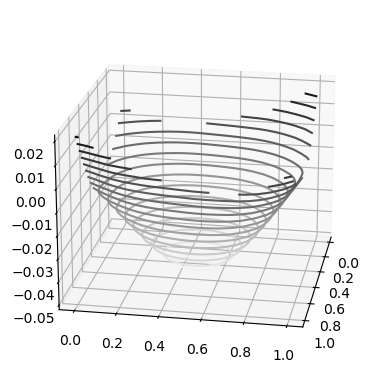

In [57]:
X = np.linspace(0, 1, num=N)
Y = np.linspace(0, 1, num=N)
X, Y = np.meshgrid(X, Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, prediction, N, cmap='binary')
ax.view_init(20, 10)

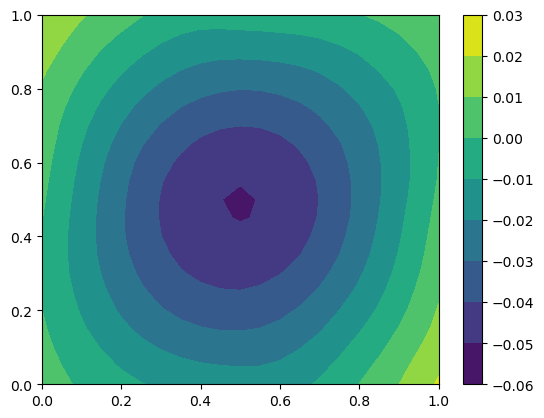

In [58]:
plt.contourf(X, Y, prediction, cmap='viridis')
plt.colorbar()
plt.show()

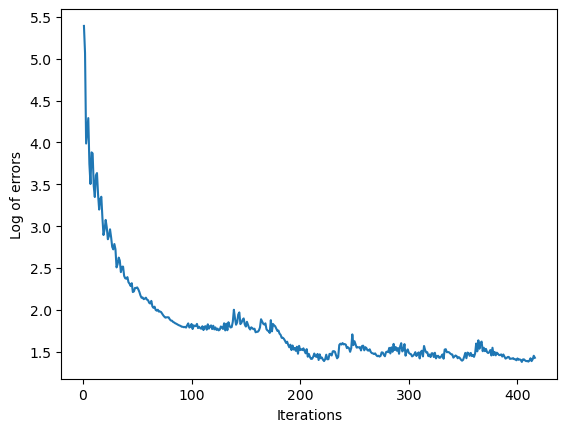

In [78]:
fig, ax = plt.subplots()
plt.ylabel("Log of errors")
plt.xlabel("Iterations")
ax.plot(range(len(errors)), np.log(errors))

In [75]:
# Error between end prediction and analytic solution

pred_reshaped = prediction.reshape([N**2,-1])
pred_row_vec = np.zeros(len(pred_reshaped))
for i in range(len(pred_reshaped)):
    pred_row_vec[i] = pred_reshaped[i][0]
loss_fn_analytic(pred_row_vec)

0.058110842570424905